
# 종합 EDA (가중치 점수 설계용): FW / MF / DF / GK

목표
- FW/MF/DF/GK 그룹별로 **세부 스탯 기반 가중치 점수**를 설계하기 전에 필요한 종합 EDA 수행
- 단순 분포 확인을 넘어서, **(1) 변별력(Prospect 구분력)**, **(2) 중복도(상관/유사 특성)**, **(3) 그룹별 가중치 초안**까지 도출

> 이 노트북은 **EDA 단계**이며, 최종 모델링(GBM/CatBoost 등)은 다음 단계에서 진행합니다.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False

TRAIN_PATH = r'C:\Users\kolan\github\DataScience\soccer\player_data\train.csv'
df = pd.read_csv(TRAIN_PATH)
print("shape:", df.shape)
df.head()


shape: (3019, 66)


,ID,Age,Height,Weight,Position,PreferredFoot,AttackingWorkRate,DefensiveWorkRate,PaceTotal,ShootingTotal,...,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating,Prospect
0,TRAIN_0000,21,182,82,CB,Right,Medium,Medium,4.6377,2.1053,...,4.9315,4.8649,6.1972,6.0000,6.1972,6.4286,6.5278,6.4286,0.875,0
1,TRAIN_0001,21,160,75,ST,Left,High,Medium,7.3913,7.3684,...,5.8904,6.4865,5.2113,4.4286,5.2113,5.0000,4.1667,5.0000,1.250,0
2,TRAIN_0002,18,165,60,RB,Right,Medium,Medium,6.2319,3.2895,...,4.9315,5.2703,5.7746,5.1429,5.7746,5.8571,5.0000,5.8571,0.750,0
3,TRAIN_0003,20,190,72,CB,Right,Medium,Medium,4.7826,1.0526,...,2.3288,2.2973,4.0845,3.7143,4.0845,4.5714,4.5833,4.5714,0.875,0
4,TRAIN_0004,21,181,77,ST,Right,High,Medium,8.2609,7.3684,...,6.3014,7.5676,5.2113,4.2857,5.2113,4.7143,3.3333,4.7143,1.125,0



## 0. 포지션 그룹 정의 & 세부 스탯 묶음

- FW: ST, CF, LW, RW, LF, RF  
- MF: CAM, CM, CDM, LM, RM  
- DF: CB, LB, RB, LWB, RWB  
- GK: GK

세부 스탯 묶음(Option A):
- FW_stats, MF_stats, DF_stats, GK_stats


In [2]:

FW = ["ST","CF","LW","RW","LF","RF"]
MF = ["CAM","CM","CDM","LM","RM"]
DF = ["CB","LB","RB","LWB","RWB"]

def map_group(pos):
    if pos in FW: return "FW"
    if pos in MF: return "MF"
    if pos in DF: return "DF"
    if pos == "GK": return "GK"
    return "ETC"

df["PosGroup"] = df["Position"].apply(map_group)

FW_stats = ["Finishing","ShotPower","Positioning","LongShots","Acceleration","SprintSpeed","Dribbling","BallControl"]
MF_stats = ["Vision","ShortPassing","LongPassing","BallControl","Dribbling","Composure","Reactions"]
DF_stats = ["Interceptions","Marking","StandingTackle","SlidingTackle","Strength","Aggression","Jumping"]
GK_stats = ["GKDiving","GKHandling","GKPositioning","GKReflexes","GKKicking"]

group_stats = {"FW": FW_stats, "MF": MF_stats, "DF": DF_stats, "GK": GK_stats}

df["PosGroup"].value_counts()


PosGroup
MF    1311
DF     908
FW     486
GK     314
Name: count, dtype: int64


## 1. 데이터 품질 체크 (결측치/타깃 분포/그룹 분포)

가중치 점수 설계 전 기본 품질 확인:
- 결측치 여부
- Prospect(타깃) 분포
- 그룹 표본 수/유망주 비율


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 67 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 3019 non-null   object 
 1   Age                3019 non-null   int64  
 2   Height             3019 non-null   int64  
 3   Weight             3019 non-null   int64  
 4   Position           3019 non-null   object 
 5   PreferredFoot      3019 non-null   object 
 6   AttackingWorkRate  3019 non-null   object 
 7   DefensiveWorkRate  3019 non-null   object 
 8   PaceTotal          3019 non-null   float64
 9   ShootingTotal      3019 non-null   float64
 10  PassingTotal       3019 non-null   float64
 11  DribblingTotal     3019 non-null   float64
 12  DefendingTotal     3019 non-null   float64
 13  PhysicalityTotal   3019 non-null   float64
 14  Crossing           3019 non-null   float64
 15  Finishing          3019 non-null   float64
 16  HeadingAccuracy    3019 

None


결측치 상위 20개:


ID                   0
Age                  0
Height               0
Weight               0
Position             0
PreferredFoot        0
AttackingWorkRate    0
DefensiveWorkRate    0
PaceTotal            0
ShootingTotal        0
PassingTotal         0
DribblingTotal       0
DefendingTotal       0
PhysicalityTotal     0
Crossing             0
Finishing            0
HeadingAccuracy      0
ShortPassing         0
Volleys              0
Dribbling            0
dtype: int64


Prospect 분포:


Prospect
0    1929
1    1090
Name: count, dtype: int64

Prospect
0    0.638953
1    0.361047
Name: ratio, dtype: float64

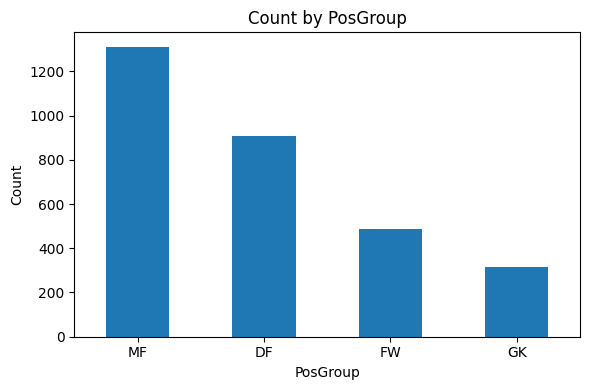

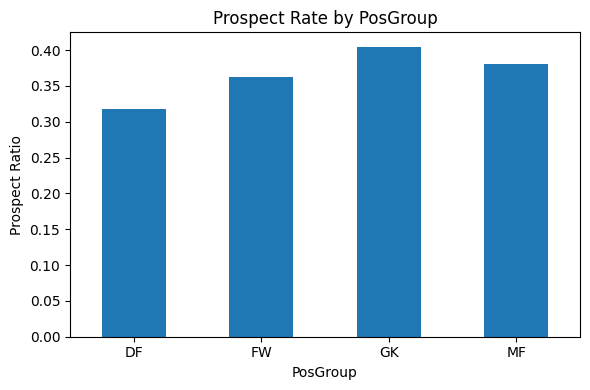

,Count,ProspectRate
PosGroup,,
MF,1311,0.380625
DF,908,0.317181
FW,486,0.362140
GK,314,0.404459


In [3]:

display(df.info())

print("\n결측치 상위 20개:")
display(df.isna().sum().sort_values(ascending=False).head(20))

print("\nProspect 분포:")
display(df["Prospect"].value_counts())
display(df["Prospect"].value_counts(normalize=True).rename("ratio"))

group_counts = df["PosGroup"].value_counts()
group_rate = df.groupby("PosGroup")["Prospect"].mean()

plt.figure(figsize=(6,4))
group_counts.plot(kind="bar")
plt.title("Count by PosGroup")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
group_rate.plot(kind="bar")
plt.title("Prospect Rate by PosGroup")
plt.ylabel("Prospect Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

display(pd.DataFrame({"Count": group_counts, "ProspectRate": group_rate}).sort_values("Count", ascending=False))



## 2. Step 1 — 스케일/분포 확인 (가중치 전에 필수)

- 가중치 점수는 **스케일/분산**에 민감합니다.  
- 동일 가중치라도 분산이 큰 피처가 더 큰 영향을 줄 수 있으므로,
  - 분포(히스토그램)
  - 표준편차(변동성)
를 먼저 봅니다.

> 아래는 그룹별로 세부 스탯의 분포를 1페이지에 요약합니다.



[FW] n=486


,mean,std,min,max
Acceleration,6.802770,1.112617,3.9759,9.7590
SprintSpeed,6.822996,1.076894,4.0244,9.7561
ShotPower,5.636779,1.001424,2.6316,10.0000
LongShots,5.895419,0.890099,2.9885,9.5402
Dribbling,6.218910,0.852237,3.5870,9.6739
BallControl,6.203592,0.821709,4.0449,9.4382
Positioning,6.129058,0.772796,3.5106,9.2553
Finishing,6.532354,0.732335,4.3956,10.0000


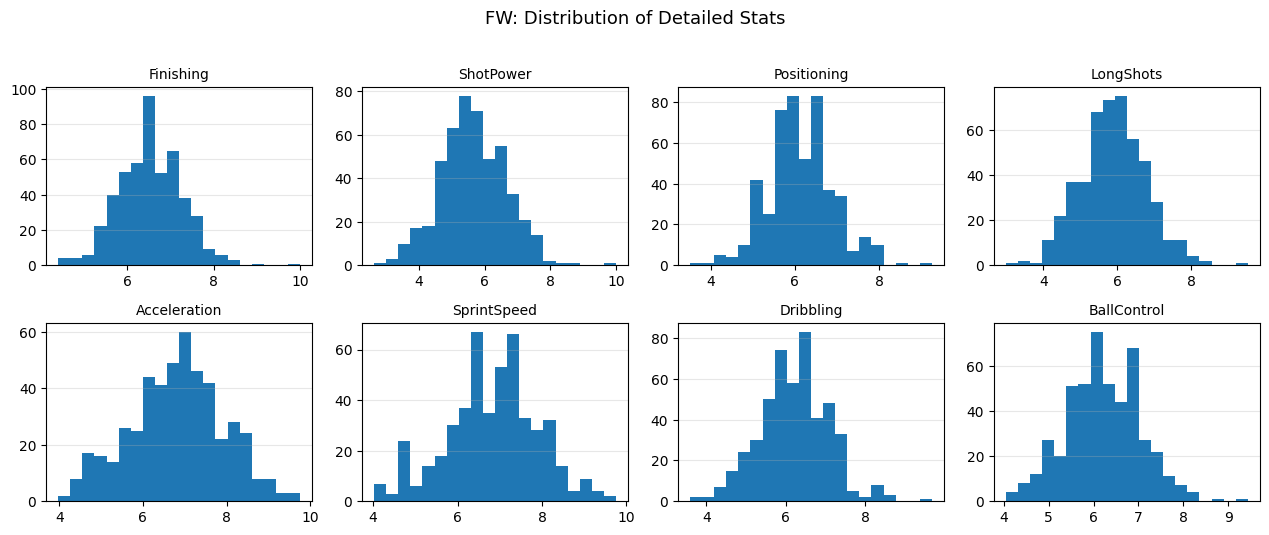


[MF] n=1311


,mean,std,min,max
Reactions,4.127335,1.230771,0.3125,8.5938
Composure,5.217023,1.071202,2.2892,8.9157
LongPassing,5.786387,0.989000,2.0238,9.0476
Vision,5.758597,0.906236,3.3333,9.2857
ShortPassing,6.306969,0.850044,3.3735,9.2771
Dribbling,6.530608,0.841145,3.8043,9.2391
BallControl,6.528001,0.799139,4.2697,9.3258


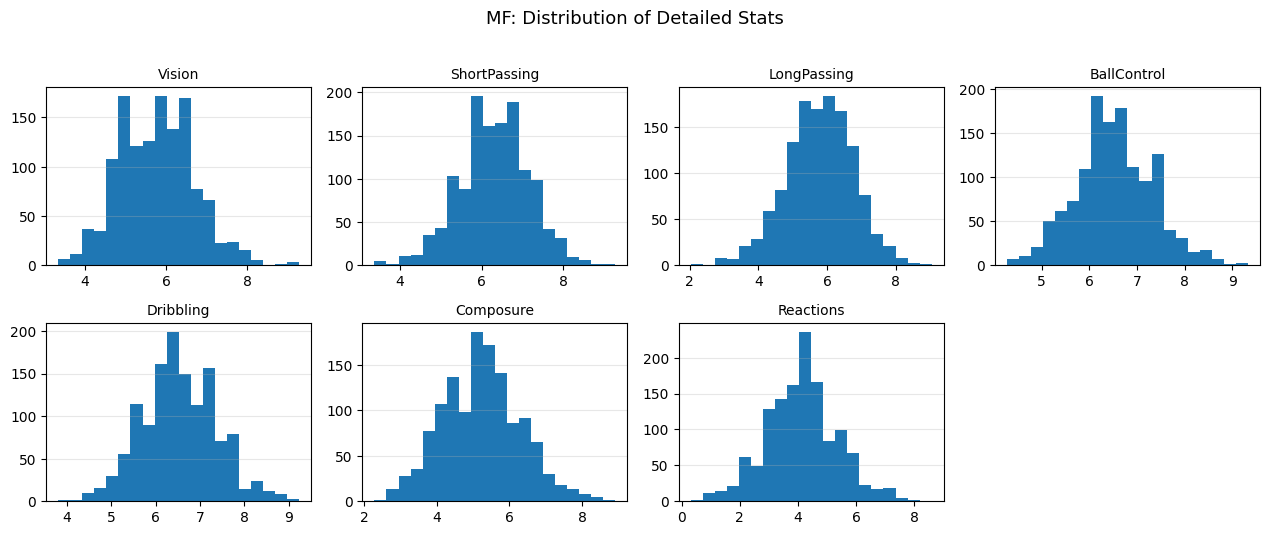


[DF] n=908


,mean,std,min,max
Strength,5.534684,1.504898,0.2817,9.5775
Jumping,6.046104,1.089578,1.2329,9.1781
Aggression,5.598860,0.979033,2.3529,8.8235
Marking,6.095263,0.755872,3.9326,8.9888
StandingTackle,6.366400,0.740553,4.5977,8.8506
SlidingTackle,6.366952,0.740106,4.4048,9.2857
Interceptions,6.237860,0.736009,4.2045,9.2045


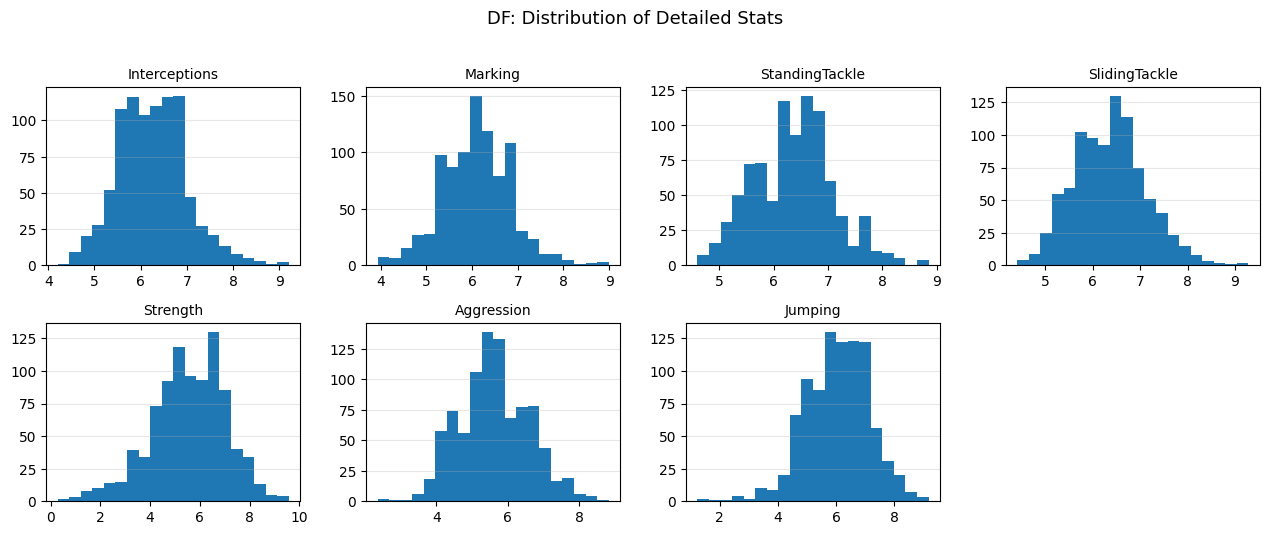


[GK] n=314


,mean,std,min,max
GKReflexes,6.512739,0.669713,4.8864,8.8636
GKPositioning,6.039508,0.663198,4.2697,8.6517
GKDiving,6.429140,0.638272,4.8864,8.7500
GKHandling,6.217068,0.608220,4.8864,8.6364
GKKicking,5.999509,0.594270,4.7253,7.9121


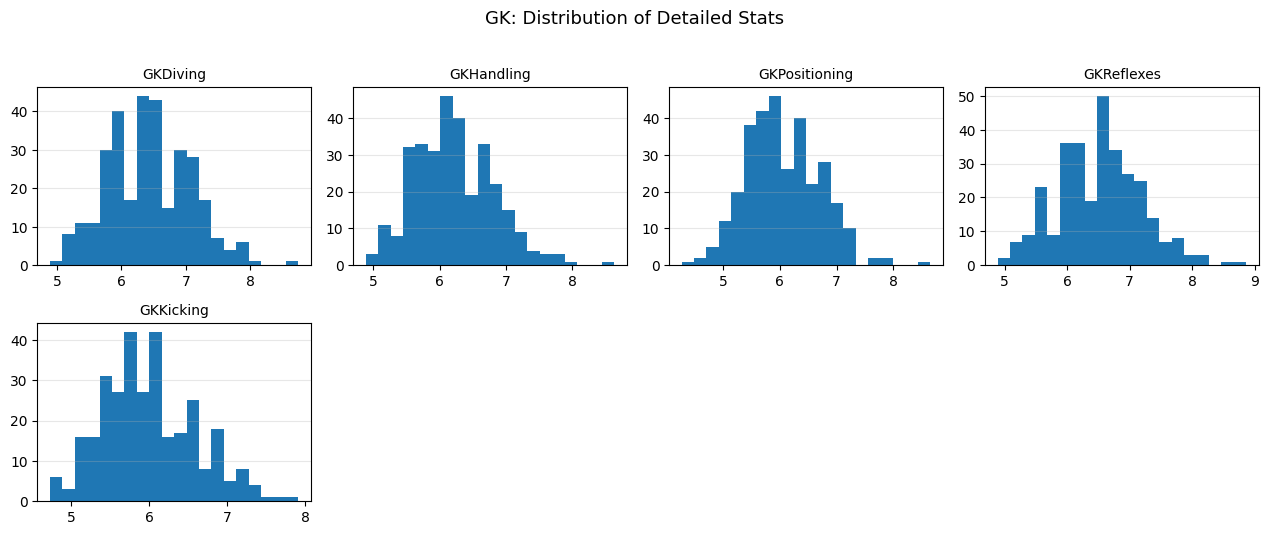

In [4]:

def plot_hist_grid(sub, cols, title, bins=20):
    n = len(cols)
    ncol = 4
    nrow = int(np.ceil(n / ncol))
    plt.figure(figsize=(ncol*3.2, nrow*2.6))
    for i, c in enumerate(cols, 1):
        plt.subplot(nrow, ncol, i)
        plt.hist(sub[c].dropna(), bins=bins)
        plt.title(c, fontsize=10)
        plt.grid(True, axis="y", alpha=0.3)
    plt.suptitle(title, y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

def stats_variability_table(sub, cols):
    return pd.DataFrame({
        "mean": sub[cols].mean(),
        "std": sub[cols].std(),
        "min": sub[cols].min(),
        "max": sub[cols].max()
    }).sort_values("std", ascending=False)

for g, cols in group_stats.items():
    sub = df[df["PosGroup"]==g]
    print(f"\n[{g}] n={len(sub)}")
    display(stats_variability_table(sub, cols))
    plot_hist_grid(sub, cols, f"{g}: Distribution of Detailed Stats")



## 3. Step 2 — Prospect 구분력 (단변량): 평균 차이, Effect Size(Cohen's d), 단일-feature AUC

가중치 설계의 핵심 근거:
- **평균 차이**: Prospect=1이 더 높은지/낮은지
- **Effect size(Cohen's d)**: 분산까지 고려한 '차이의 크기' (가중치 우선순위 근거로 좋음)
- **단일-feature AUC**: 한 피처만으로 Prospect를 얼마나 잘 구분하는지

> 주의: 표본 수가 적은 그룹/포지션은 변동성이 커질 수 있습니다.



==== FW Univariate Report (top) ====


,feature,mean_P0,mean_P1,mean_diff,cohens_d,auc_1d,abs_d
0,LongShots,6.055620,5.613248,-0.442372,-0.511311,0.359925,0.511311
1,Positioning,6.251544,5.913317,-0.338227,-0.447242,0.376320,0.447242
2,BallControl,6.331645,5.978043,-0.353602,-0.439401,0.384430,0.439401
3,ShotPower,5.791173,5.364835,-0.426338,-0.434505,0.373112,0.434505
4,Finishing,6.644449,6.334914,-0.309535,-0.431243,0.377575,0.431243
5,Dribbling,6.340812,6.004195,-0.336617,-0.401896,0.395299,0.401896
6,SprintSpeed,6.890637,6.703855,-0.186783,-0.173874,0.442339,0.173874
7,Acceleration,6.867085,6.689489,-0.177596,-0.159928,0.445995,0.159928



==== MF Univariate Report (top) ====


,feature,mean_P0,mean_P1,mean_diff,cohens_d,auc_1d,abs_d
0,Reactions,4.383081,3.711171,-0.671911,-0.565980,0.346579,0.565980
1,ShortPassing,6.448011,6.077459,-0.370552,-0.445863,0.370696,0.445863
2,Composure,5.382812,4.947243,-0.435569,-0.414630,0.387542,0.414630
3,BallControl,6.647345,6.333798,-0.313547,-0.399528,0.381156,0.399528
4,LongPassing,5.926872,5.557782,-0.369090,-0.379337,0.389298,0.379337
5,Vision,5.885671,5.551814,-0.333856,-0.374300,0.392544,0.374300
6,Dribbling,6.640605,6.351614,-0.288991,-0.348322,0.403664,0.348322



==== DF Univariate Report (top) ====


,feature,mean_P0,mean_P1,mean_diff,cohens_d,auc_1d,abs_d
0,SlidingTackle,6.477345,6.129301,-0.348043,-0.481692,0.363738,0.481692
1,Marking,6.202977,5.863378,-0.339598,-0.459193,0.374479,0.459193
2,Interceptions,6.335960,6.026673,-0.309287,-0.428269,0.374835,0.428269
3,StandingTackle,6.459586,6.165793,-0.293793,-0.403446,0.384767,0.403446
4,Aggression,5.674005,5.437089,-0.236916,-0.243406,0.426658,0.243406
5,Strength,5.605861,5.381456,-0.224405,-0.149395,0.453917,0.149395
6,Jumping,6.071144,5.992198,-0.078946,-0.072457,0.478495,0.072457



==== GK Univariate Report (top) ====


,feature,mean_P0,mean_P1,mean_diff,cohens_d,auc_1d,abs_d
0,GKPositioning,6.187589,5.821468,-0.366122,-0.572662,0.341067,0.572662
1,GKHandling,6.334468,6.044202,-0.290267,-0.490156,0.348078,0.490156
2,GKDiving,6.540470,6.265214,-0.275255,-0.440575,0.372858,0.440575
3,GKReflexes,6.626152,6.345745,-0.280408,-0.427175,0.371974,0.427175
4,GKKicking,6.083914,5.875227,-0.208688,-0.355949,0.390185,0.355949


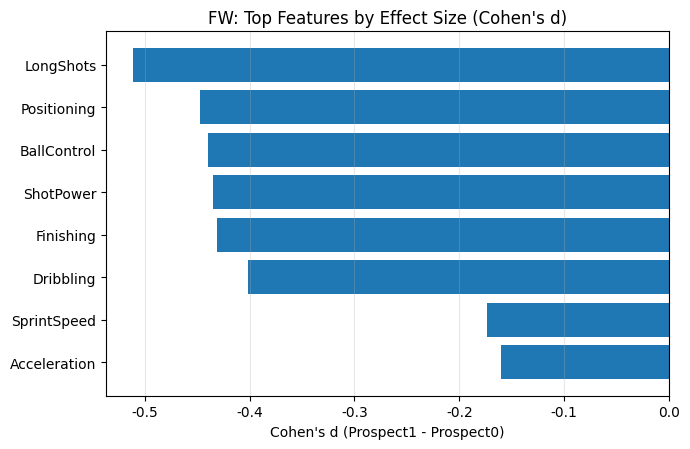

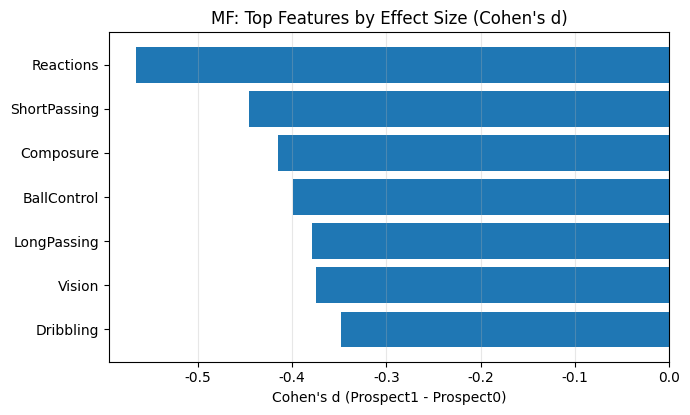

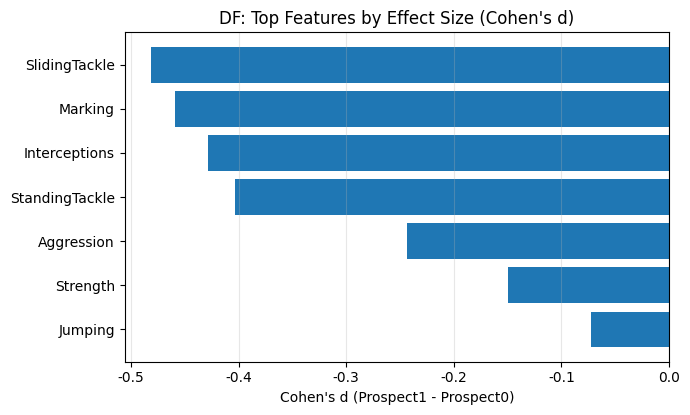

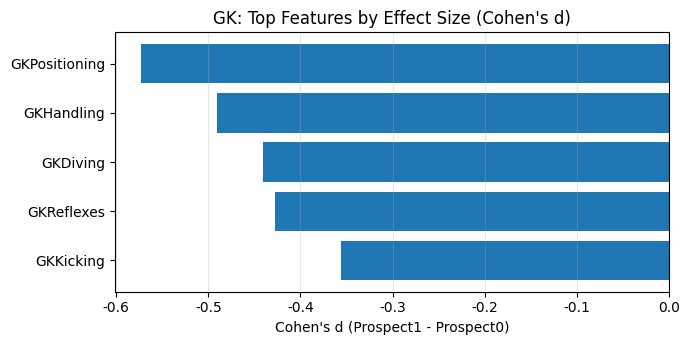

In [5]:

def cohens_d(x1, x0):
    # x1: Prospect=1, x0: Prospect=0
    x1 = np.asarray(x1); x0 = np.asarray(x0)
    x1 = x1[~np.isnan(x1)]; x0 = x0[~np.isnan(x0)]
    n1, n0 = len(x1), len(x0)
    if n1 < 2 or n0 < 2:
        return np.nan
    s1, s0 = x1.std(ddof=1), x0.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1*s1 + (n0-1)*s0*s0) / (n1+n0-2))
    if sp == 0:
        return 0.0
    return (x1.mean() - x0.mean()) / sp

def auc_1d(y_true, scores):
    # AUC = P(score_pos > score_neg) + 0.5 P(equal)
    y = np.asarray(y_true).astype(int)
    s = np.asarray(scores).astype(float)
    pos = s[y==1]; neg = s[y==0]
    if len(pos)==0 or len(neg)==0:
        return np.nan
    # rank-based computation
    combined = np.concatenate([pos, neg])
    ranks = pd.Series(combined).rank(method="average").to_numpy()
    r_pos = ranks[:len(pos)].sum()
    n1, n0 = len(pos), len(neg)
    auc = (r_pos - n1*(n1+1)/2) / (n1*n0)
    return float(auc)

def univariate_report(sub, cols):
    out = []
    y = sub["Prospect"].values
    for c in cols:
        x = sub[c].values
        x1 = x[y==1]; x0 = x[y==0]
        diff = np.nanmean(x1) - np.nanmean(x0)
        d = cohens_d(x1, x0)
        a = auc_1d(y, x)
        out.append([c, np.nanmean(x0), np.nanmean(x1), diff, d, a])
    rep = pd.DataFrame(out, columns=["feature","mean_P0","mean_P1","mean_diff","cohens_d","auc_1d"])
    # 변별력 기준 정렬: abs(cohens_d) 우선, 동률이면 AUC
    rep["abs_d"] = rep["cohens_d"].abs()
    return rep.sort_values(["abs_d","auc_1d"], ascending=False).reset_index(drop=True)

reports = {}
for g, cols in group_stats.items():
    sub = df[df["PosGroup"]==g]
    if sub["Prospect"].nunique() < 2:
        continue
    rep = univariate_report(sub, cols)
    reports[g] = rep
    print(f"\n==== {g} Univariate Report (top) ====")
    display(rep.head(20))

# 시각화: 그룹별 |cohens_d| 막대그래프(상위 k)
def plot_top_effect(rep, title, k=10):
    top = rep.head(k).copy()
    # 부호 포함 막대(차이 방향)
    plt.figure(figsize=(7, 0.35*k + 1.8))
    plt.barh(top["feature"][::-1], top["cohens_d"][::-1])
    plt.title(title)
    plt.xlabel("Cohen's d (Prospect1 - Prospect0)")
    plt.grid(True, axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

for g, rep in reports.items():
    plot_top_effect(rep, f"{g}: Top Features by Effect Size (Cohen's d)", k=min(10, len(rep)))



## 4. Step 3 — 중복도(상관) 분석: 가중치 중복 방지

- 비슷한 피처끼리(예: Acceleration vs SprintSpeed, Dribbling vs BallControl) 높은 상관을 가질 수 있습니다.
- 상관이 높은 피처들에 동시에 큰 가중치를 주면 **중복 반영**이 발생합니다.

여기서는:
- 그룹별 상관행렬(heatmap)
- 높은 상관 쌍(top pairs)
을 확인합니다.


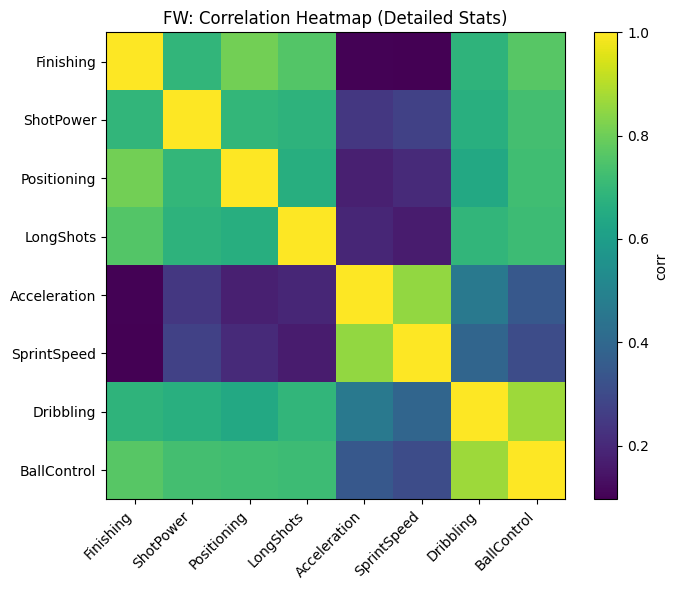


[FW] 높은 상관 쌍(절대값 기준, |corr|>=0.7)


,f1,f2,corr,abs_corr
27,Dribbling,BallControl,0.868679,0.868679
22,Acceleration,SprintSpeed,0.853805,0.853805
1,Finishing,Positioning,0.806266,0.806266
6,Finishing,BallControl,0.764727,0.764727
2,Finishing,LongShots,0.758162,0.758162
12,ShotPower,BallControl,0.728233,0.728233
17,Positioning,BallControl,0.723981,0.723981
21,LongShots,BallControl,0.717019,0.717019


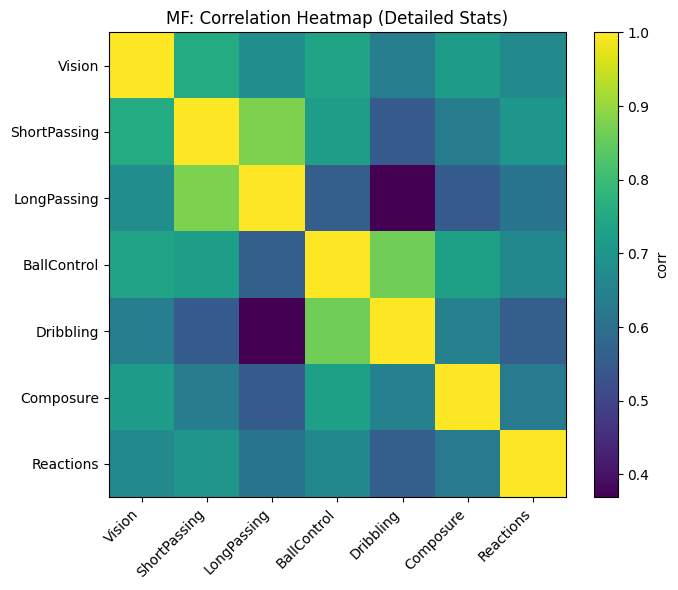


[MF] 높은 상관 쌍(절대값 기준, |corr|>=0.7)


,f1,f2,corr,abs_corr
6,ShortPassing,LongPassing,0.874759,0.874759
15,BallControl,Dribbling,0.863783,0.863783
0,Vision,ShortPassing,0.757248,0.757248
2,Vision,BallControl,0.737342,0.737342
16,BallControl,Composure,0.728076,0.728076
7,ShortPassing,BallControl,0.720604,0.720604
4,Vision,Composure,0.714204,0.714204
10,ShortPassing,Reactions,0.701234,0.701234


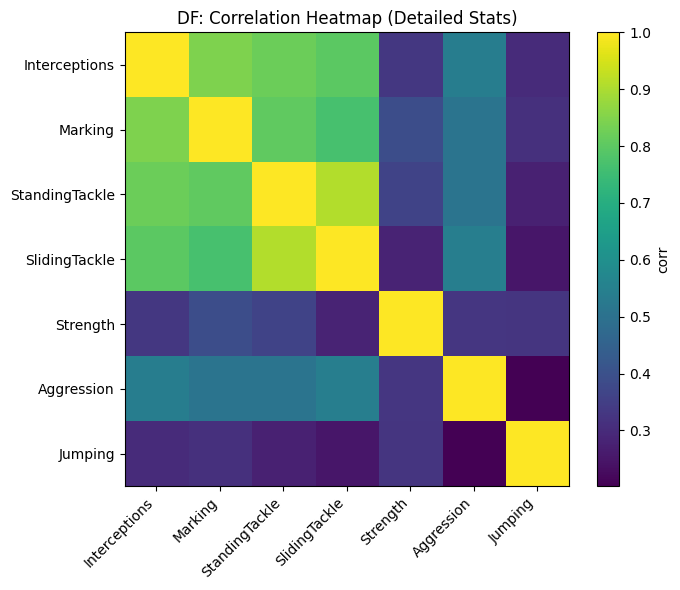


[DF] 높은 상관 쌍(절대값 기준, |corr|>=0.7)


,f1,f2,corr,abs_corr
11,StandingTackle,SlidingTackle,0.908620,0.908620
0,Interceptions,Marking,0.845101,0.845101
1,Interceptions,StandingTackle,0.821130,0.821130
6,Marking,StandingTackle,0.805402,0.805402
2,Interceptions,SlidingTackle,0.799561,0.799561
7,Marking,SlidingTackle,0.766840,0.766840


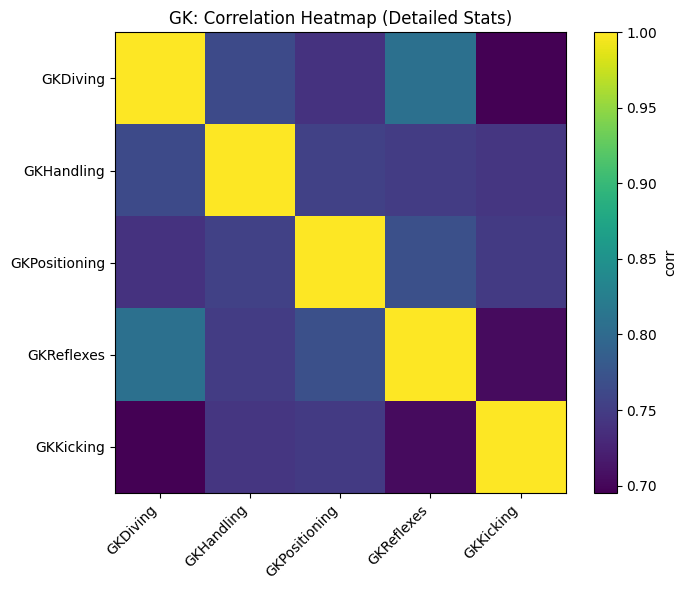


[GK] 높은 상관 쌍(절대값 기준, |corr|>=0.7)


,f1,f2,corr,abs_corr
2,GKDiving,GKReflexes,0.807885,0.807885
7,GKPositioning,GKReflexes,0.769134,0.769134
0,GKDiving,GKHandling,0.763734,0.763734
4,GKHandling,GKPositioning,0.753560,0.753560
5,GKHandling,GKReflexes,0.749040,0.749040
8,GKPositioning,GKKicking,0.747430,0.747430
6,GKHandling,GKKicking,0.742766,0.742766
1,GKDiving,GKPositioning,0.739912,0.739912
9,GKReflexes,GKKicking,0.704584,0.704584


In [6]:

def corr_heatmap(sub, cols, title):
    corr = sub[cols].corr()
    plt.figure(figsize=(7,6))
    plt.imshow(corr.values, aspect="auto")
    plt.title(title)
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.yticks(range(len(cols)), cols)
    plt.colorbar(label="corr")
    plt.tight_layout()
    plt.show()
    return corr

def top_corr_pairs(corr, k=10, threshold=0.7):
    # upper triangle pairs
    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr.iloc[i, j]
            pairs.append((cols[i], cols[j], val, abs(val)))
    pairs = pd.DataFrame(pairs, columns=["f1","f2","corr","abs_corr"]).sort_values("abs_corr", ascending=False)
    return pairs[(pairs["abs_corr"]>=threshold)].head(k)

for g, cols in group_stats.items():
    sub = df[df["PosGroup"]==g]
    if len(cols) < 2:
        continue
    corr = corr_heatmap(sub, cols, f"{g}: Correlation Heatmap (Detailed Stats)")
    print(f"\n[{g}] 높은 상관 쌍(절대값 기준, |corr|>=0.7)")
    display(top_corr_pairs(corr, k=20, threshold=0.7))



## 5. Step 4 — 그룹 점수(서브스코어) 후보 만들기: 표준화 + 가중합

가중치 점수 설계의 출발점으로, 다음을 수행합니다:
1) 그룹별로 세부 스탯을 **z-score 표준화**  
2) **Effect size 기반 가중치 초안**(abs(Cohen's d) 비례) 생성  
3) 그룹별 서브스코어(FW_score, MF_score, DF_score, GK_score) 산출  
4) 서브스코어가 Prospect와 어느 정도 분리되는지(분포/단일-feature AUC) 확인

> 여기서 나온 가중치는 “최종”이 아니라, **데이터 기반 초안**입니다.



[FW] Effect 기반 가중치(초안)


,weight
feature,
LongShots,-0.170471
Positioning,-0.149111
BallControl,-0.146496
ShotPower,-0.144864
Finishing,-0.143776
Dribbling,-0.133992
SprintSpeed,-0.057969
Acceleration,-0.053320



[MF] Effect 기반 가중치(초안)


,weight
feature,
Reactions,-0.193302
ShortPassing,-0.152278
Composure,-0.141610
BallControl,-0.136453
LongPassing,-0.129557
Vision,-0.127836
Dribbling,-0.118964



[DF] Effect 기반 가중치(초안)


,weight
feature,
SlidingTackle,-0.215247
Marking,-0.205193
Interceptions,-0.191374
StandingTackle,-0.180282
Aggression,-0.108768
Strength,-0.066758
Jumping,-0.032378



[GK] Effect 기반 가중치(초안)


,weight
feature,
GKPositioning,-0.250452
GKHandling,-0.214368
GKDiving,-0.192684
GKReflexes,-0.186823
GKKicking,-0.155673


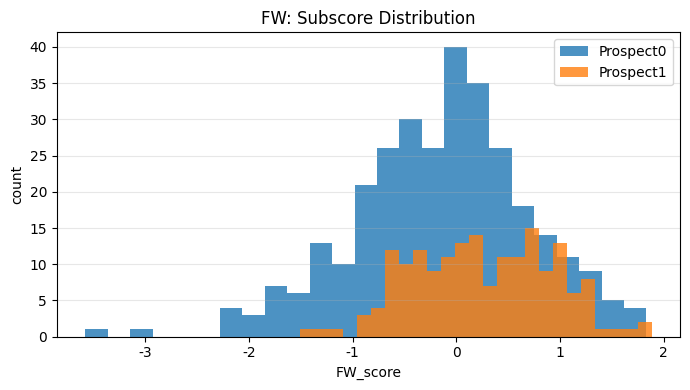

FW subscore AUC (1D): 0.6403


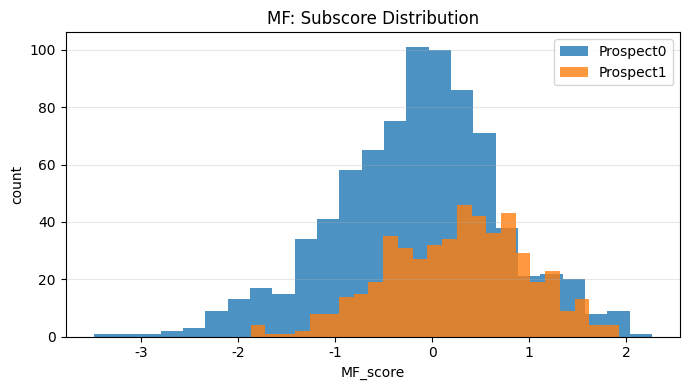

MF subscore AUC (1D): 0.6460


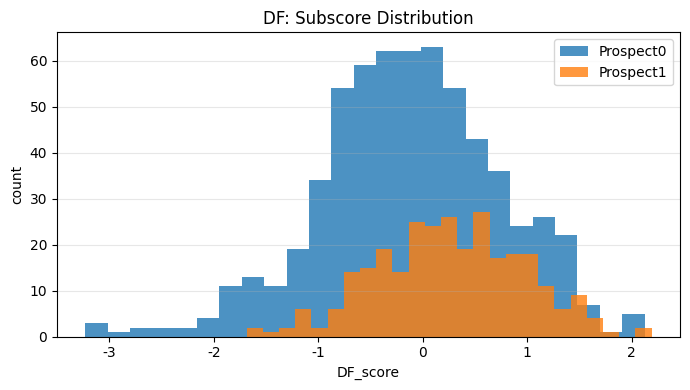

DF subscore AUC (1D): 0.6318


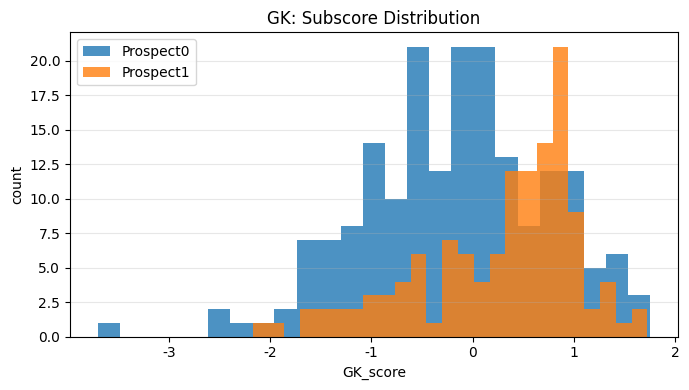

GK subscore AUC (1D): 0.6573


In [7]:

def zscore(series):
    s = series.astype(float)
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return s*0.0
    return (s - mu) / sd

def build_weights_from_effect(rep, method="abs_d", floor=0.0):
    # method: abs_d
    w = rep.set_index("feature")[method].copy()
    w = w.fillna(0.0)
    # 음수/양수 방향은 diff에서 따로 반영 가능하지만,
    # 점수는 "높을수록 유망"이 되도록 부호를 맞추기 위해 mean_diff 부호를 곱해줌
    sign = rep.set_index("feature")["mean_diff"].apply(lambda x: 1.0 if x>=0 else -1.0)
    w = w * sign
    # 최소값 컷(너무 작은 가중치 제거 옵션)
    w = w.where(w.abs() >= floor, other=0.0)
    # 정규화: 가중치 절대값 합이 1이 되도록
    denom = w.abs().sum()
    if denom == 0:
        return w
    return w / denom

subscores = {}
weights = {}

for g, cols in group_stats.items():
    sub = df[df["PosGroup"]==g].copy()
    if sub["Prospect"].nunique() < 2:
        continue
    
    rep = reports[g].copy()
    w = build_weights_from_effect(rep, method="abs_d", floor=0.0)
    weights[g] = w
    
    # 표준화 후 가중합 (전체 df에 score 컬럼 추가)
    score = pd.Series(0.0, index=sub.index)
    for c in cols:
        score += zscore(sub[c]) * w.get(c, 0.0)
    subscores[g] = score
    
    df.loc[sub.index, f"{g}_score"] = score

# 가중치 테이블 출력
for g, w in weights.items():
    print(f"\n[{g}] Effect 기반 가중치(초안)")
    display(w.sort_values(key=lambda s: s.abs(), ascending=False).to_frame("weight"))

# 그룹별 score 분포 및 AUC
def plot_score_distribution(sub, score_col, title):
    s0 = sub[sub["Prospect"]==0][score_col].dropna()
    s1 = sub[sub["Prospect"]==1][score_col].dropna()
    plt.figure(figsize=(7,4))
    plt.hist(s0, bins=25, alpha=0.8, label="Prospect0")
    plt.hist(s1, bins=25, alpha=0.8, label="Prospect1")
    plt.title(title)
    plt.xlabel(score_col)
    plt.ylabel("count")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

for g in ["FW","MF","DF","GK"]:
    col = f"{g}_score"
    sub = df[df["PosGroup"]==g]
    if col in df.columns and sub["Prospect"].nunique()>=2:
        plot_score_distribution(sub, col, f"{g}: Subscore Distribution")
        auc = auc_1d(sub["Prospect"].values, sub[col].values)
        print(f"{g} subscore AUC (1D): {auc:.4f}")



## 6. Step 5 — “종합 점수” 시나리오(EDA): 그룹 스코어 + 성장/맥락 변수 합치기

여기서는 아직 모델링이 아닌 EDA 관점에서, **설명 가능한 종합 점수**를 만들어봅니다.

예시 종합 점수:
- 그룹 서브스코어(해당 그룹 score) + (나이 보정) + (워크레이트 보정)

### (A) 나이 보정 아이디어
- 일반적으로(데이터셋/과제 정의에 따라 다름) **어릴수록 성장 잠재력**이 있다고 보는 경우가 많습니다.
- `Age`는 16~21 범위이므로, 예시로 `Age_z`를 사용해 ( -Age_z )를 더해 '어릴수록' 점수를 약간 올리는 방식

### (B) 워크레이트 보정 아이디어
- AttackingWorkRate / DefensiveWorkRate: Low / Medium / High
- 이를 점수로 매핑(예: Low=0, Medium=1, High=2) 후 표준화하여 소량 가산

> ⚠️ 과제 정의가 “잠재력”인지 “현재 능력”인지에 따라 Age 보정의 방향은 달라질 수 있습니다.


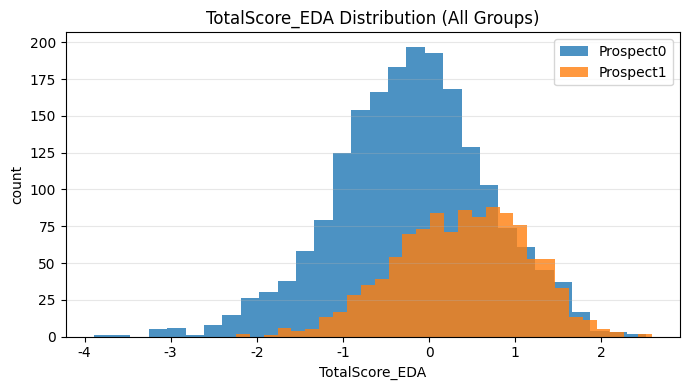

TotalScore_EDA AUC (1D): 0.6926


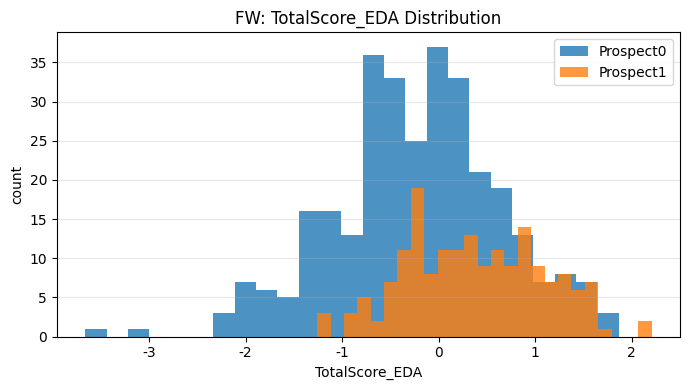

FW TotalScore_EDA AUC (1D): 0.6993


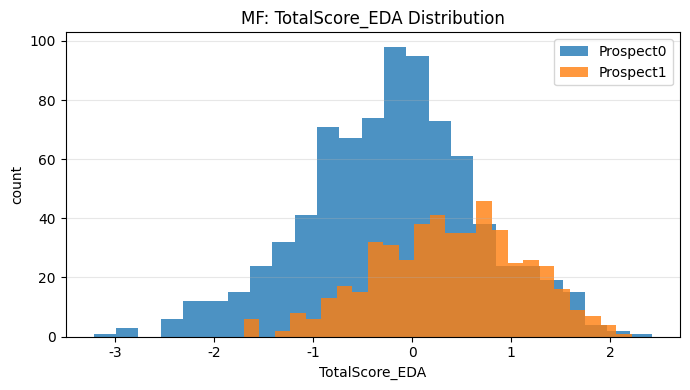

MF TotalScore_EDA AUC (1D): 0.6958


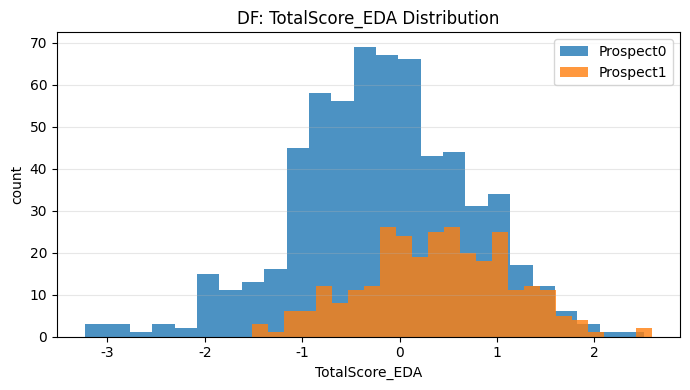

DF TotalScore_EDA AUC (1D): 0.6840


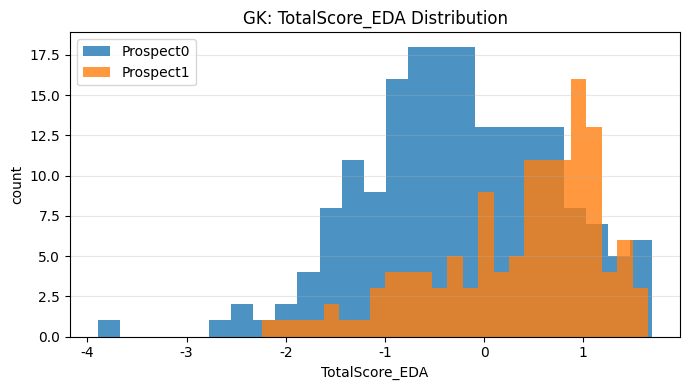

GK TotalScore_EDA AUC (1D): 0.6919


In [8]:

# 워크레이트 매핑
wr_map = {"Low":0, "Medium":1, "High":2}
df["AWR_num"] = df["AttackingWorkRate"].map(wr_map).astype(float)
df["DWR_num"] = df["DefensiveWorkRate"].map(wr_map).astype(float)

# 표준화(전체 기준)
df["Age_z"] = zscore(df["Age"])
df["AWR_z"] = zscore(df["AWR_num"])
df["DWR_z"] = zscore(df["DWR_num"])

# 종합 점수 예시(EDA용): 해당 그룹 score + (어릴수록 가점) + 워크레이트 가점
# 가중치는 예시이며, 이 노트북에서는 '검토' 목적
ALPHA_AGE = 0.15
BETA_WR   = 0.10

def build_total_score(row):
    g = row["PosGroup"]
    base = row.get(f"{g}_score", np.nan)
    if pd.isna(base):
        base = 0.0
    age_term = (-row["Age_z"]) * ALPHA_AGE   # 어릴수록 +
    wr_term = (0.5*row["AWR_z"] + 0.5*row["DWR_z"]) * BETA_WR
    return base + age_term + wr_term

df["TotalScore_EDA"] = df.apply(build_total_score, axis=1)

# 전체 분포
plt.figure(figsize=(7,4))
s0 = df[df["Prospect"]==0]["TotalScore_EDA"]
s1 = df[df["Prospect"]==1]["TotalScore_EDA"]
plt.hist(s0, bins=30, alpha=0.8, label="Prospect0")
plt.hist(s1, bins=30, alpha=0.8, label="Prospect1")
plt.title("TotalScore_EDA Distribution (All Groups)")
plt.xlabel("TotalScore_EDA")
plt.ylabel("count")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("TotalScore_EDA AUC (1D):", round(auc_1d(df["Prospect"].values, df["TotalScore_EDA"].values), 4))

# 그룹별 확인
for g in ["FW","MF","DF","GK"]:
    sub = df[df["PosGroup"]==g]
    if sub["Prospect"].nunique()<2: 
        continue
    plt.figure(figsize=(7,4))
    plt.hist(sub[sub["Prospect"]==0]["TotalScore_EDA"], bins=25, alpha=0.8, label="Prospect0")
    plt.hist(sub[sub["Prospect"]==1]["TotalScore_EDA"], bins=25, alpha=0.8, label="Prospect1")
    plt.title(f"{g}: TotalScore_EDA Distribution")
    plt.xlabel("TotalScore_EDA")
    plt.ylabel("count")
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"{g} TotalScore_EDA AUC (1D): {auc_1d(sub['Prospect'].values, sub['TotalScore_EDA'].values):.4f}")



## 7. 결과 정리: “가중치 설계”에 바로 쓰는 표

- 그룹별 피처 변별력(Effect size, AUC) 표
- 그룹별 권장 가중치(초안) 표
- (옵션) 상관 높은 피처 쌍 → 중복 제거 후보
- 최종 TotalScore_EDA 성능(단일 점수 AUC) 요약


In [9]:
# 요약 테이블: 그룹별 univariate top + weights
summary_rows = []
for g, rep in reports.items():
    top = rep.copy()
    top["group"] = g
    top = top[["group","feature","cohens_d","auc_1d","mean_diff"]]
    summary_rows.append(top)

summary = pd.concat(summary_rows, axis=0)

# (안전) 숫자형 변환
summary["cohens_d"] = pd.to_numeric(summary["cohens_d"], errors="coerce")
summary["auc_1d"]   = pd.to_numeric(summary["auc_1d"], errors="coerce")
summary["mean_diff"]= pd.to_numeric(summary["mean_diff"], errors="coerce")

# 그룹별 |cohens_d| 기준으로 정렬하기 위한 컬럼
summary["abs_d"] = summary["cohens_d"].abs()

# group은 문자열이므로 그대로 1차 정렬, 2차는 abs_d로 정렬
summary = summary.sort_values(["group", "abs_d"], ascending=[True, False])

display(summary.groupby("group").head(10).drop(columns=["abs_d"]))

# TotalScore_EDA 상위 유망주 후보 (train 내에서) - 참고용 (라벨 있음)
top_candidates = df.sort_values("TotalScore_EDA", ascending=False).head(20)[
    ["ID","Position","PosGroup","Age","TotalScore_EDA","Prospect"]
]
display(top_candidates)


,group,feature,cohens_d,auc_1d,mean_diff
0,DF,SlidingTackle,-0.481692,0.363738,-0.348043
1,DF,Marking,-0.459193,0.374479,-0.339598
2,DF,Interceptions,-0.428269,0.374835,-0.309287
3,DF,StandingTackle,-0.403446,0.384767,-0.293793
4,DF,Aggression,-0.243406,0.426658,-0.236916
5,DF,Strength,-0.149395,0.453917,-0.224405
6,DF,Jumping,-0.072457,0.478495,-0.078946
0,FW,LongShots,-0.511311,0.359925,-0.442372
1,FW,Positioning,-0.447242,0.376320,-0.338227
2,FW,BallControl,-0.439401,0.384430,-0.353602


,ID,Position,PosGroup,Age,TotalScore_EDA,Prospect
1099,TRAIN_1099,RB,DF,17,2.588145,1
2111,TRAIN_2111,RWB,DF,17,2.513529,0
74,TRAIN_0074,RB,DF,17,2.484519,1
529,TRAIN_0529,RM,MF,19,2.423864,0
1044,TRAIN_1044,RM,MF,17,2.218447,1
381,TRAIN_0381,ST,FW,16,2.208532,1
2435,TRAIN_2435,ST,FW,17,2.176031,1
2080,TRAIN_2080,CDM,MF,19,2.146666,0
1181,TRAIN_1181,RWB,DF,18,2.129919,0
2772,TRAIN_2772,CDM,MF,17,2.117121,0


In [10]:
thr = df["TotalScore_EDA"].quantile(0.7)
pred = (df["TotalScore_EDA"] > thr).astype(int)

from sklearn.metrics import classification_report
print(classification_report(df["Prospect"], pred))


              precision    recall  f1-score   support

           0       0.72      0.79      0.76      1929
           1       0.56      0.46      0.51      1090

    accuracy                           0.67      3019
   macro avg       0.64      0.63      0.63      3019
weighted avg       0.66      0.67      0.67      3019



In [11]:
from sklearn.metrics import precision_recall_fscore_support

for q in [0.5, 0.6, 0.7, 0.8]:
    thr = df["TotalScore_EDA"].quantile(q)
    pred = (df["TotalScore_EDA"] > thr).astype(int)
    p, r, f, _ = precision_recall_fscore_support(
        df["Prospect"], pred, average="binary"
    )
    print(f"q={q:.1f} | precision={p:.2f}, recall={r:.2f}, f1={f:.2f}")


q=0.5 | precision=0.49, recall=0.68, f1=0.57
q=0.6 | precision=0.52, recall=0.58, f1=0.55
q=0.7 | precision=0.56, recall=0.46, f1=0.51
q=0.8 | precision=0.58, recall=0.32, f1=0.42


모델 생성

In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -------------------------
# 0) 컬럼 체크 & 자동 수정
# -------------------------
# Scouting_Score가 없으면 TotalScore_EDA를 대신 쓰기
score_col = "Scouting_Score"
if score_col not in df.columns:
    if "TotalScore_EDA" in df.columns:
        score_col = "TotalScore_EDA"
        print("⚠️ 'Scouting_Score' 컬럼이 없어서 'TotalScore_EDA'로 대체합니다.")
    else:
        raise KeyError("❌ 'Scouting_Score'도 없고 'TotalScore_EDA'도 없습니다. 점수 컬럼부터 생성해야 합니다.")

# 1) Features / Target (점수 컬럼만 동적으로 반영)
features = ['Age', score_col, 'Acceleration', 'Finishing', 'Agility',
            'ShortPassing', 'Balance', 'Weight', 'Height', 'Stamina']

# 혹시 df에 없는 컬럼이 섞였으면 제거(안전장치)
missing = [c for c in features if c not in df.columns]
if missing:
    raise KeyError(f"❌ df에 없는 컬럼이 features에 포함되어 있습니다: {missing}")

X = df[features].copy()
y = df['Prospect'].copy()

# -------------------------
# 2) CV 설정
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# 3) 모델 정의
# -------------------------
models = [
    ('RF',  RandomForestClassifier(random_state=42, n_estimators=400, n_jobs=-1)),
    ('ET',  ExtraTreesClassifier(random_state=42, n_estimators=600, n_jobs=-1)),
    ('GBM', GradientBoostingClassifier(random_state=42)),
    ('ADA', AdaBoostClassifier(random_state=42)),
    ('LGBM', LGBMClassifier(random_state=42)),
    ('XGB', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('LR',  LogisticRegression(random_state=42, max_iter=3000)),
    ('SVM', SVC(probability=True, random_state=42))
]

# -------------------------
# 4) 평가 지표
# -------------------------
scoring = {
    'acc': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall'
}

print("📊 모델별 교차검증 성능 (mean ± std)")
results = []

for name, model in models:
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    row = {
        'model': name,
        'acc_mean': scores['test_acc'].mean(),
        'f1_mean': scores['test_f1'].mean(),
        'auc_mean': scores['test_roc_auc'].mean(),
        'precision_mean': scores['test_precision'].mean(),
        'recall_mean': scores['test_recall'].mean(),
        'acc_std': scores['test_acc'].std(),
        'f1_std': scores['test_f1'].std(),
    }
    results.append(row)

    print(f"{name:5} | acc={row['acc_mean']:.4f}±{row['acc_std']:.4f} "
          f"| f1={row['f1_mean']:.4f}±{row['f1_std']:.4f} "
          f"| auc={row['auc_mean']:.4f} "
          f"| prec={row['precision_mean']:.4f} | rec={row['recall_mean']:.4f}")

best = max(results, key=lambda r: r['f1_mean'])
print(f"\n🏆 최적 모델 (기준: F1): {best['model']}  (F1={best['f1_mean']:.4f}, AUC={best['auc_mean']:.4f})")


⚠️ 'Scouting_Score' 컬럼이 없어서 'TotalScore_EDA'로 대체합니다.
📊 모델별 교차검증 성능 (mean ± std)
RF    | acc=0.7748±0.0035 | f1=0.6667±0.0121 | auc=0.8387 | prec=0.7162 | rec=0.6248
ET    | acc=0.7751±0.0123 | f1=0.6691±0.0234 | auc=0.8415 | prec=0.7137 | rec=0.6312
GBM   | acc=0.7804±0.0120 | f1=0.6798±0.0162 | auc=0.8453 | prec=0.7190 | rec=0.6459
ADA   | acc=0.7854±0.0108 | f1=0.6997±0.0132 | auc=0.8451 | prec=0.7077 | rec=0.6927
LGBM  | acc=0.7705±0.0107 | f1=0.6651±0.0115 | auc=0.8322 | prec=0.7040 | rec=0.6312
XGB   | acc=0.7668±0.0103 | f1=0.6602±0.0106 | auc=0.8198 | prec=0.6984 | rec=0.6275
LR    | acc=0.7807±0.0100 | f1=0.6745±0.0139 | auc=0.8497 | prec=0.7276 | rec=0.6294
SVM   | acc=0.7814±0.0129 | f1=0.6603±0.0211 | auc=0.8406 | prec=0.7528 | rec=0.5890

🏆 최적 모델 (기준: F1): ADA  (F1=0.6997, AUC=0.8451)


autogluon

In [14]:
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# -------------------------
# 1) 사용할 컬럼 정의
# -------------------------
features = [
    'Age', 'TotalScore_EDA',
    'Acceleration', 'Finishing', 'Agility',
    'ShortPassing', 'Balance', 'Weight', 'Height', 'Stamina',
    'PreferredFoot', 'AttackingWorkRate', 'DefensiveWorkRate',
    'Position', 'PosGroup'
]

# 존재하는 컬럼만 사용 (안전)
features = [c for c in features if c in df.columns]

data = df[features + ['Prospect']].copy()

# -------------------------
# 2) Train / Validation split
# -------------------------
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    stratify=data['Prospect'],
    random_state=42
)

# -------------------------
# 3) AutoGluon Predictor
# -------------------------
predictor = TabularPredictor(
    label='Prospect',
    eval_metric='f1',          # 지금 문제에 가장 적합
    path='autogluon_prospect'
)

# -------------------------
# 4) 학습
# -------------------------
predictor.fit(
    train_data=train_data,
    time_limit=600,            # 10분 (원하면 늘려도 됨)
    presets='medium_quality',    # 성능 최우선
)

# -------------------------
# 5) 성능 평가
# -------------------------
performance = predictor.evaluate(test_data)
print(performance)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          14
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       11.98 GB / 31.53 GB (38.0%)
Disk Space Avail:   117.16 GB / 212.20 GB (55.2%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "c:\Users\kolan\Downloads\autogluon_prospect"
Train Data Rows:    2415
Train Data Columns: 15
Label Column:       Prospect
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [np.int64(0), np.int64(1)]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may spe

{'f1': 0.6921241050119332, 'accuracy': 0.7864238410596026, 'balanced_accuracy': np.float64(0.7600299472358226), 'mcc': 0.5300596077859839, 'roc_auc': np.float64(0.8423848457479678), 'precision': 0.7213930348258707, 'recall': 0.6651376146788991}


(_dystack pid=26336) Deleting DyStack predictor artifacts (clean_up_fits=True) ...


In [15]:
leaderboard = predictor.leaderboard(test_data, silent=True)
leaderboard


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.718894,0.668493,f1,0.006033,0.009119,23.230039,0.006033,0.009119,23.230039,1,True,5
1,NeuralNetTorch,0.702326,0.681199,f1,0.012250,0.012785,19.258370,0.012250,0.012785,19.258370,1,True,10
2,WeightedEnsemble_L2,0.692124,0.687324,f1,0.023785,0.024658,20.768119,0.001512,0.000000,0.222201,2,True,12
3,XGBoost,0.687500,0.687151,f1,0.010023,0.011873,1.287549,0.010023,0.011873,1.287549,1,True,9
4,RandomForestEntr,0.684086,0.653409,f1,0.075756,0.088680,0.786771,0.075756,0.088680,0.786771,1,True,4
5,NeuralNetFastAI,0.683146,0.666667,f1,0.022719,0.020180,21.382451,0.022719,0.020180,21.382451,1,True,8
6,LightGBMLarge,0.680751,0.668539,f1,0.007617,0.009408,26.825049,0.007617,0.009408,26.825049,1,True,11
7,LightGBM,0.677570,0.679666,f1,0.004776,0.008857,2.670856,0.004776,0.008857,2.670856,1,True,2
8,ExtraTreesEntr,0.674641,0.655172,f1,0.081692,0.101044,0.996425,0.081692,0.101044,0.996425,1,True,7
9,ExtraTreesGini,0.671463,0.631579,f1,0.081978,0.100791,1.099504,0.081978,0.100791,1.099504,1,True,6


어떤 지표가 영향을 많이 미쳤는지?

In [16]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 15 features using 604 rows with 5 shuffle sets...
	2.55s	= Expected runtime (0.51s per shuffle set)
	0.5s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Age,0.297910,0.023391,0.000005,5,0.346072,0.249749
Balance,0.015512,0.005875,0.002060,5,0.027609,0.003415
TotalScore_EDA,0.012927,0.018579,0.097371,5,0.051181,-0.025328
Stamina,0.009165,0.009096,0.043676,5,0.027893,-0.009563
Agility,0.005923,0.004164,0.016749,5,0.014497,-0.002650
Height,0.003557,0.008383,0.198237,5,0.020817,-0.013703
Weight,0.001977,0.007709,0.298520,5,0.017850,-0.013896
PreferredFoot,0.000967,0.002466,0.215044,5,0.006044,-0.004110
DefensiveWorkRate,-0.000334,0.000746,0.813050,5,0.001203,-0.001871
PosGroup,-0.002298,0.003474,0.893350,5,0.004856,-0.009451


✅ 3) 유망주 확률 Top10

In [17]:
import numpy as np

# AutoGluon이 학습에 사용한 feature만 선택
used_features = predictor.feature_metadata_in.get_features()
X_train = df[[c for c in used_features if c in df.columns]].copy()

# 유망주(Prospect=1) 확률 예측
proba = predictor.predict_proba(X_train)

# Prospect=1 확률 안전하게 추출
if hasattr(proba, "columns") and 1 in proba.columns:
    df["Prospect_Prob"] = proba[1].values
elif hasattr(proba, "columns") and "1" in proba.columns:
    df["Prospect_Prob"] = proba["1"].values
else:
    df["Prospect_Prob"] = np.array(proba)[:, 1]


In [18]:
TOP_N = 10  # 원하는 숫자로 변경
topN_train = df.sort_values("Prospect_Prob", ascending=False).head(TOP_N)

show_cols = [c for c in ["ID","Position","PosGroup","Age","Prospect_Prob","Prospect"] if c in topN_train.columns]
topN_train[show_cols]


,ID,Position,PosGroup,Age,Prospect_Prob,Prospect
2840,TRAIN_2840,CAM,MF,16,0.974050,1
1521,TRAIN_1521,CAM,MF,16,0.967119,1
2321,TRAIN_2321,CDM,MF,18,0.967080,1
1817,TRAIN_1817,CAM,MF,17,0.964919,1
2048,TRAIN_2048,CAM,MF,17,0.964657,1
1804,TRAIN_1804,CAM,MF,17,0.964245,1
1470,TRAIN_1470,CAM,MF,18,0.964204,1
540,TRAIN_0540,CAM,MF,17,0.963018,1
2130,TRAIN_2130,CAM,MF,18,0.962612,1
1255,TRAIN_1255,CAM,MF,16,0.962344,1


In [24]:
# -------------------------
# 전체 랭킹 기준 Top-30
# -------------------------
TOP_N = 30

top30 = df.sort_values("Prospect_Prob", ascending=False).head(TOP_N)

save_cols = [c for c in [
    "ID", "Position", "PosGroup", "Age",
    "Prospect_Prob", "Prospect"
] if c in top30.columns]

top30 = top30[save_cols]

# -------------------------
# 상대경로로 바로 저장 (핵심)
# -------------------------
top30.to_csv(
    "top30_prospects.csv",
    index=False,
    encoding="utf-8-sig"
)

print("저장 완료!")


저장 완료!
